In [1]:
import utils_data as ut
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertForMaskedLM, BertTokenizer
tokenizerBERT = BertTokenizer.from_pretrained('pranav-s/MaterialsBERT', model_max_length=512)
modelBERT = BertForMaskedLM.from_pretrained('pranav-s/MaterialsBERT')

In [2]:
classes = {'POLYMER': 1,
           'ORGANIC': 2,
           'MONOMER': 3,
           'PROP_NAME': 4,
           'INORGANIC': 5,
           'MATERIAL_AMOUNT': 6,
           'POLYMER_FAMILY': 7,
           'PROP_VALUE': 8,
           'O': 0}
max_length = 512
batch_size = 3
class NERBERTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = modelBERT.base_model
        self.linear = nn.Linear(768, len(classes) + 1)
        
    def forward(self, token, attention_mask):
        encoder_output= self.bert(token, attention_mask)  # torch.LongTensor of shape (batch_size, sequence_length)
        linear_output = self.linear(encoder_output.last_hidden_state)
#         class_output = F.softmax(linear_output, dim=2)
        return linear_output#class_output

In [3]:
model = NERBERTModel()

In [4]:
num_data = 200
data_list = ut.read_data('train.json', max_length)[:num_data]

In [5]:
token_tensors_all_list = [ut.list2token(tokenizerBERT, d['words'], max_length) for d in data_list]
data = torch.cat(token_tensors_all_list, dim=0)
data_batches = ut.to_batches(data, batch_size)
target_tensors_all_list = [ut.cat2digit(classes, d['ner'], max_length)[0] for d in data_list]
target = torch.stack(target_tensors_all_list, dim=0)
target_batches = ut.to_batches(target, batch_size)
att_mask_all_list = [ut.cat2digit(classes, d['ner'], max_length)[1] for d in data_list]
att_mask = torch.stack(att_mask_all_list, dim=0)
att_mask_batches = ut.to_batches(att_mask, batch_size)

In [6]:
c = list(zip(data_batches, target_batches, att_mask_batches))
random.shuffle(c)
data_batches, target_batches, att_mask_batches = zip(*c)

In [7]:
# counts = torch.unique(target, return_counts=True)[1][:-1]
# weights = sum(counts) / counts
# weights_n = weights / torch.norm(weights)
# weights_n = torch.cat((weights_n, torch.tensor([0])))
weights = torch.tensor([0.01, 0.5, 1, 1, 0.8, 1, 1, 1, 0.5, 0.0])
weights_n = weights / torch.norm(weights)
criterion = nn.CrossEntropyLoss(weight=weights_n)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
torch.manual_seed(42)

In [8]:
epochs = 5
train_losses = []
train_accuracy = []
for epoch in range(epochs):
    train_loss_batch = []
    train_accuracy_batch = []
    for b, X in enumerate(data_batches):
        y_pred = model(X, attention_mask=att_mask_batches[b])
        y_pred = torch.swapaxes(y_pred, 1, 2)
        y = target_batches[b]
        
        loss = criterion(y_pred, y)
        acc, predicted_classes, true_classes = ut.accuracy(0, len(classes), y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_batch.append(loss.item())
        train_accuracy_batch.append(acc)
        if b % 100 == 0:
            print(f'epoch: {epoch:2}  batch: {b:3}  loss: {loss.item():.6f}   accuracy: {acc:.4f}')
            print(predicted_classes)
    
    train_loss_batch_mean = sum(train_loss_batch) / len(train_loss_batch)
    train_accuracy_batch_mean = sum(train_accuracy_batch) / len(train_accuracy_batch)    
    print(f'mean training loss at epoch {epoch}: {train_loss_batch_mean}')
    print(f'mean training accuracy at epoch {epoch}: {train_accuracy_batch_mean}')
    train_losses.append(train_loss_batch_mean)
    train_accuracy.append(train_accuracy_batch_mean)

epoch:  0  batch:   0  loss: 2.320706   accuracy: 0.0320
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 8, 0, 0, 8,
        0, 6, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 3, 0, 3, 8, 0, 8, 0,
        3, 0, 3, 0, 3, 0, 0, 8, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 8, 0, 0, 0, 8, 8,
        8, 0, 0, 5, 5, 7, 8, 8, 8, 3, 0, 8, 3, 0, 8, 3, 0, 0, 8, 0, 0, 0, 8, 8,
        8, 3, 0, 8, 0, 0, 1, 8, 0, 3, 0, 0, 8, 3, 0, 8, 0, 3, 0, 0, 3, 0, 3, 0,
        0, 0, 0, 0, 0])
mean training loss at epoch 0: 1.1576788839119583
mean training accuracy at epoch 0: 0.6792226433753967
epoch:  1  batch:   0  loss: 0.796332   accuracy: 0.8240
tensor([7, 7, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 0, 7, 0, 0, 7, 3, 4, 8, 8, 8, 4, 4,
        8, 8, 8, 8, 7, 7, 0, 0, 7, 7, 7, 7, 3, 0, 4, 4, 8, 8, 8, 8, 4, 4, 4, 8,
        8, 8, 8, 8, 8, 8, 4, 4, 8, 8, 8, 3, 3, 3, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1,
        1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 4, 4, 4, 4, 4, 4,
        5, 5, 5, 7, 7, 7, 4, 4, 8, 8, 

In [9]:
train_accuracy

[tensor(0.6792),
 tensor(0.8352),
 tensor(0.8777),
 tensor(0.8969),
 tensor(0.9323)]

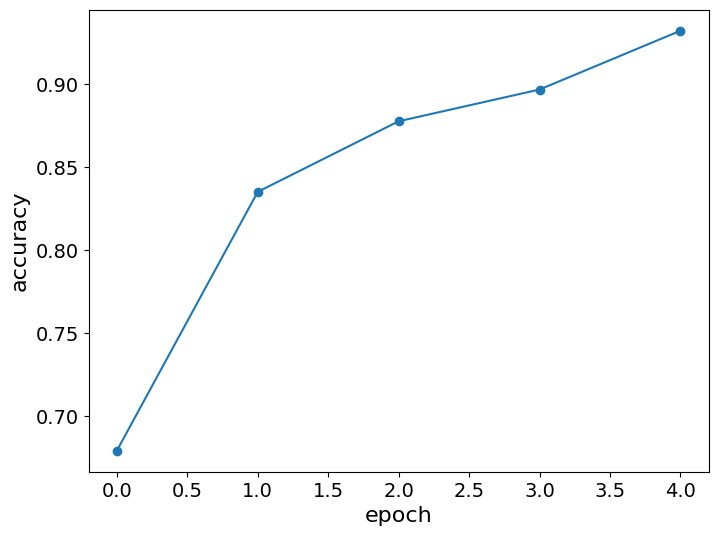

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_accuracy, 'o-')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

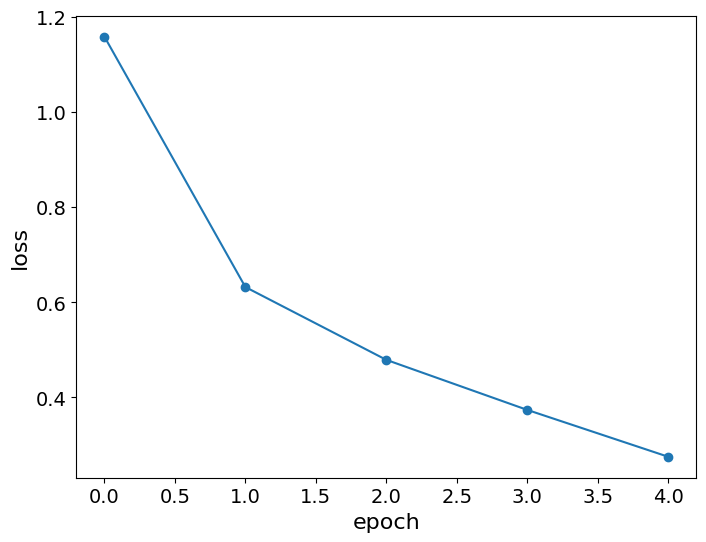

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, 'o-')
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [12]:
torch.unique(target, return_counts=True)[1][:-1]

tensor([37607,  1815,   219,   513,  1233,   307,   225,   419,  1665])

In [13]:
weights_n

tensor([0.0040, 0.2018, 0.4036, 0.4036, 0.3229, 0.4036, 0.4036, 0.4036, 0.2018,
        0.0000])